Zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.

Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu. Takie rozwiązania nie będą oceniane

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.


In [14]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
BATCH_SIZE = 32
TRAIN_DATA_PATH = './data/train'
TEST_DATA_PATH = './data/test_all'

In [17]:
transform = transforms.Compose([
     transforms.Resize((64, 64)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_aug = transforms.Compose([
     transforms.Resize((64, 64)),
     transforms.RandomHorizontalFlip(0.1),  
     transforms.RandomVerticalFlip(0.1),
     transforms.RandomRotation(10), 
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = ImageFolder(root=TRAIN_DATA_PATH, transform=transform_aug)
test_dataset = ImageFolder(root=TRAIN_DATA_PATH, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

folders = sorted(os.listdir(TRAIN_DATA_PATH))
classes = {index: value for index, value in enumerate(folders)}

print(classes)

{0: 'acoustic', 1: 'antenna', 2: 'bacteria', 3: 'battery', 4: 'bean', 5: 'beetle', 6: 'bicycle', 7: 'birch', 8: 'bird', 9: 'bomb', 10: 'bread', 11: 'bridge', 12: 'camera', 13: 'carbon', 14: 'cat', 15: 'corn', 16: 'crab', 17: 'crocodilian', 18: 'echinoderm', 19: 'egg', 20: 'elephant', 21: 'fish', 22: 'flower', 23: 'frog', 24: 'fungus', 25: 'gauge', 26: 'hammer', 27: 'icecream', 28: 'kangaroo', 29: 'memorial', 30: 'monkey', 31: 'motor', 32: 'nest', 33: 'palm', 34: 'pizza', 35: 'pot', 36: 'printer', 37: 'saw', 38: 'snake', 39: 'spice', 40: 'spider', 41: 'spoon', 42: 'squash', 43: 'swine', 44: 'tea', 45: 'tomato', 46: 'towel', 47: 'truck', 48: 'turtle', 49: 'worm'}


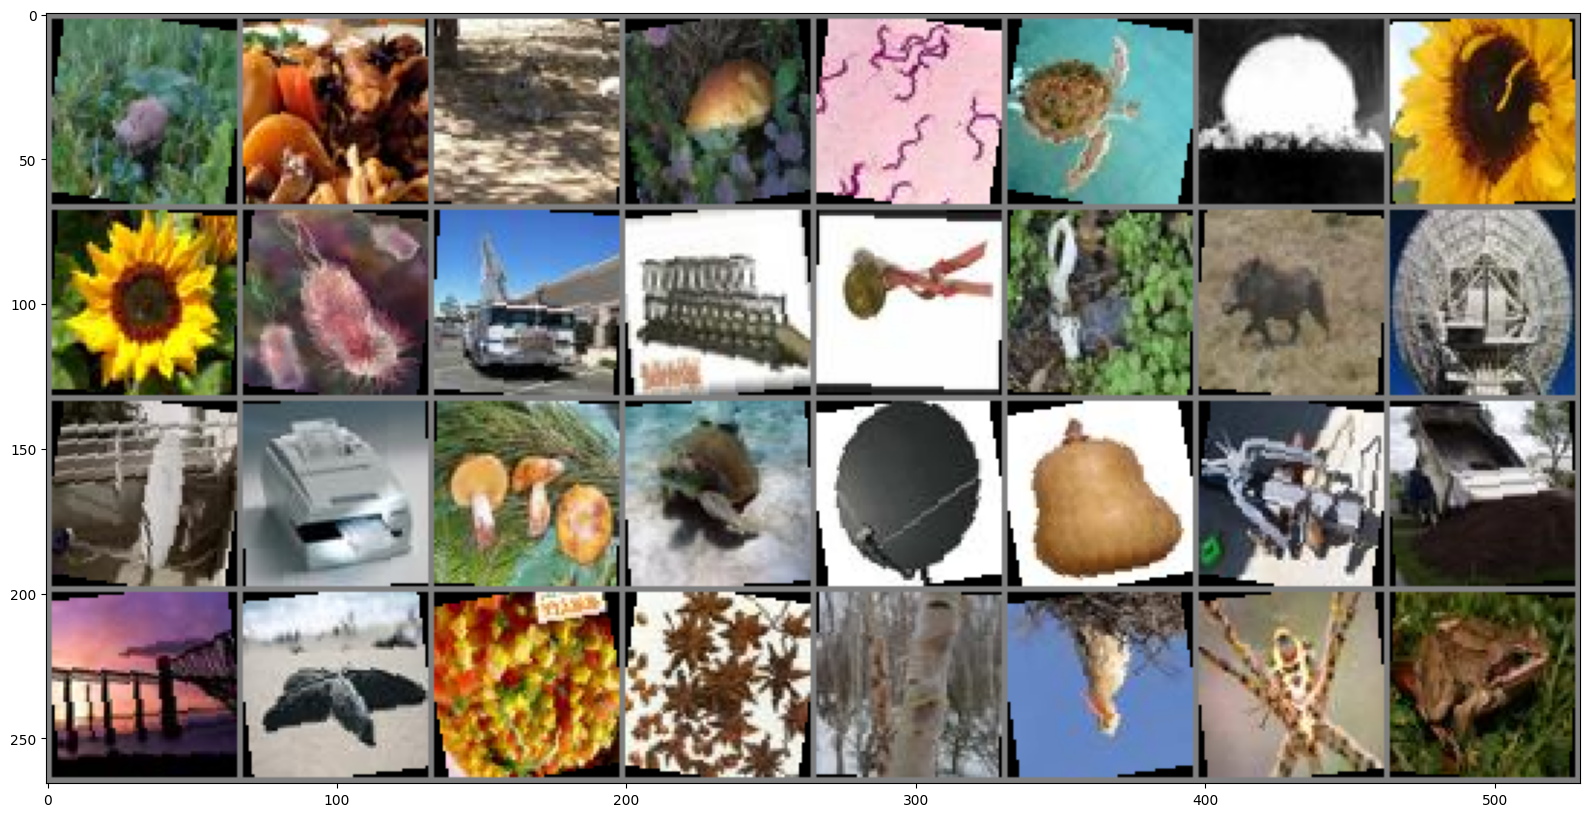

fungus spice kangaroo fungus bacteria turtle  bomb flower flower bacteria truck bridge acoustic  bomb swine antenna antenna printer fungus turtle antenna squash   saw truck bridge echinoderm  corn spice birch  nest spider  frog


In [18]:
plt.figure(figsize = (20,10))

images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j].item()] for j in range(BATCH_SIZE)))

In [22]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=50):
        super(ImageClassifier, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
          #  nn.BatchNorm2d(6),
            nn.ReLU(),
           nn.Dropout(p=0.05),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=0),
          #  nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(p=0.05),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3, padding=0),
        #    nn.BatchNorm2d(18),
            nn.ReLU(),
           nn.Dropout(p=0.1),
        )
        
        self.fc1 = nn.Linear(18 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        # self.pool3 = nn.AdaptiveAvgPool2d((4,4))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.block1(x)
        x = self.pool2(self.block2(x))
        x = self.pool3(self.block3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100


In [38]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f"{epoch+1}/{epochs}] loss: {running_loss / 2000:.3f}")
    running_loss = 0.0
    if epoch%10 == 0:
        torch.save(model.state_dict(), f'./models/cnn_final_e{epoch}.pth')

torch.save(model.state_dict(), f'./models/cnn_final.pth')
print('Finished Training')


KeyboardInterrupt: 

In [62]:
model = ImageClassifier().to(device)
checkpoint = torch.load(f'models/cnn_final_e60.pth')
model.load_state_dict(checkpoint)

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = model(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(total)

print(f'Accuracy of the network on the entire dataset: %d %%' % (
    100 * correct / total))


88011
Accuracy of the network on the entire dataset: 65 %


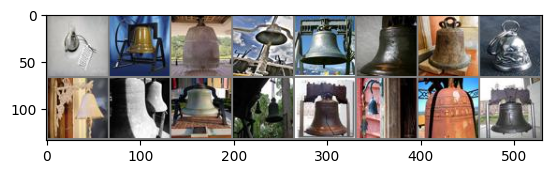

GroundTruth:  acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic acoustic
Predicted:  spider acoustic memorial acoustic acoustic acoustic acoustic acoustic towel acoustic   tea elephant acoustic acoustic acoustic acoustic


In [63]:
# Test dla 16 przykładowych obrazków

images, labels = next(iter(test_loader))
images = images[:16]

# print images
imshow(torchvision.utils.make_grid(images))
outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(16)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(16)))

In [64]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes.values()}
total_pred = {classname: 0 for classname in classes.values()}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        images = images.to(device)
        outputs = model(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class acoustic is: 57.4 %
Accuracy for class antenna is: 65.5 %
Accuracy for class bacteria is: 72.1 %
Accuracy for class battery is: 58.1 %
Accuracy for class bean  is: 61.6 %
Accuracy for class beetle is: 74.9 %
Accuracy for class bicycle is: 71.6 %
Accuracy for class birch is: 61.8 %
Accuracy for class bird  is: 45.1 %
Accuracy for class bomb  is: 69.4 %
Accuracy for class bread is: 67.0 %
Accuracy for class bridge is: 55.6 %
Accuracy for class camera is: 76.9 %
Accuracy for class carbon is: 65.6 %
Accuracy for class cat   is: 60.8 %
Accuracy for class corn  is: 49.6 %
Accuracy for class crab  is: 53.5 %
Accuracy for class crocodilian is: 54.1 %
Accuracy for class echinoderm is: 52.9 %
Accuracy for class egg   is: 66.3 %
Accuracy for class elephant is: 75.0 %
Accuracy for class fish  is: 63.3 %
Accuracy for class flower is: 92.9 %
Accuracy for class frog  is: 59.9 %
Accuracy for class fungus is: 72.6 %
Accuracy for class gauge is: 67.8 %
Accuracy for class hammer is: 86

In [67]:
from PIL import Image

class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_paths = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        image_path = os.path.join(self.folder_path, image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_name

dataset = UnlabeledImageDataset(TEST_DATA_PATH, transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions = []

with torch.no_grad():
    for images, image_names in data_loader:
        images = images.to(device)
        outputs = model(images).cpu()
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend([(image_name, predicted_item.item()) for image_name, predicted_item in zip(image_names, predicted)])


df = pd.DataFrame(predictions, columns=['Image_name', 'Predicted_class'])
df.to_csv('kieruczenko_ziarek_project3_predictions.csv', index=False, header=False)

df.head()


,Image_name,Predicted_class
0,4791371793430632.JPEG,26
1,38662959153360865.JPEG,19
2,8186064211941618.JPEG,7
3,8979200762231442.JPEG,8
4,10019170175687653.JPEG,30


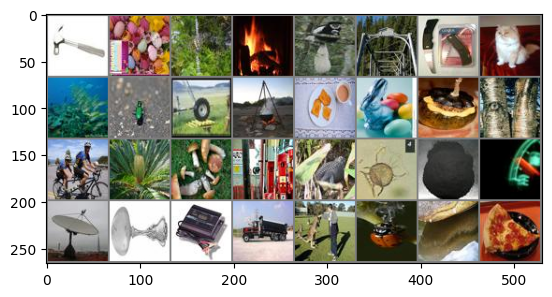

Predicted:  hammer   egg spider  bird monkey memorial  bird icecream  fish beetle swine bicycle flower   egg icecream acoustic bicycle  palm beetle battery  nest icecream   pot beetle acoustic spoon printer motor bicycle  frog printer pizza


In [66]:
# Test dla 32 przykładowych obrazków
images, labels = next(iter(data_loader))
images = images[:32]

# print images
imshow(torchvision.utils.make_grid(images))
outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(32)))